In [1]:
# Model Explainability with SHAP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
import sys
sys.path.append('../src')
from model_explainability import (
    create_shap_explainer, 
    create_explanation_report,
    plot_shap_summary,
    plot_shap_bar,
    plot_shap_waterfall,
    plot_shap_dependence,
    analyze_fraud_patterns
)

print("="*80)
print(" MODEL EXPLAINABILITY WITH SHAP")
print("="*80)
print("1. Use SHAP to interpret your best-performing model")
print("2. Generate SHAP plots (Summary Plot, Force Plot)")
print("3. Explain key drivers of fraud in the data")
print("="*80)

 MODEL EXPLAINABILITY WITH SHAP
1. Use SHAP to interpret your best-performing model
2. Generate SHAP plots (Summary Plot, Force Plot)
3. Explain key drivers of fraud in the data


In [2]:
# Load the data and models
print("Loading data and models ")

# Load the prepared data
fraud_data = pd.read_csv('../data/processed/fraud_data_cleaned.csv')

# Recreate the preprocessing steps 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# Prepare features and target
X_fraud = fraud_data.drop(['class', 'signup_time', 'purchase_time'], axis=1)
y_fraud = fraud_data['class']

# Split data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42
)

# Preprocessing 
high_cardinality = ['user_id', 'device_id']
categorical_cols = ['source', 'browser', 'sex', 'country']
numeric_cols = [col for col in X_train_fraud.columns if col not in high_cardinality + categorical_cols]

# Drop high-cardinality columns
X_train_fraud_reduced = X_train_fraud.drop(columns=high_cardinality)
X_test_fraud_reduced = X_test_fraud.drop(columns=high_cardinality)

# One-hot encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_fraud_encoded = encoder.fit_transform(X_train_fraud_reduced[categorical_cols])
X_test_fraud_encoded = encoder.transform(X_test_fraud_reduced[categorical_cols])

# Get numeric columns
X_train_fraud_num = X_train_fraud_reduced.drop(columns=categorical_cols).reset_index(drop=True)
X_test_fraud_num = X_test_fraud_reduced.drop(columns=categorical_cols).reset_index(drop=True)

# Combine numeric and encoded categorical features
X_train_fraud_prepared = pd.concat(
    [X_train_fraud_num, pd.DataFrame(X_train_fraud_encoded, columns=encoder.get_feature_names_out(categorical_cols))],
    axis=1
)
X_test_fraud_prepared = pd.concat(
    [X_test_fraud_num, pd.DataFrame(X_test_fraud_encoded, columns=encoder.get_feature_names_out(categorical_cols))],
    axis=1
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_fraud_res, y_train_fraud_res = smote.fit_resample(X_train_fraud_prepared, y_train_fraud.reset_index(drop=True))

# Scale numeric features
scaler_fraud = StandardScaler()
numeric_cols_fraud = [
    'purchase_value', 'age', 'ip_address', 'hour_of_day', 'day_of_week',
    'time_since_signup', 'user_transaction_count', 'device_transaction_count',
    'user_transaction_velocity', 'ip_address_int'
]

X_train_fraud_scaled = X_train_fraud_res.copy()
X_test_fraud_scaled = X_test_fraud_prepared.copy()

X_train_fraud_scaled[numeric_cols_fraud] = scaler_fraud.fit_transform(X_train_fraud_res[numeric_cols_fraud])
X_test_fraud_scaled[numeric_cols_fraud] = scaler_fraud.transform(X_test_fraud_prepared[numeric_cols_fraud])

print("Data loaded and preprocessed!")
print(f"Training set shape: {X_train_fraud_scaled.shape}")
print(f"Test set shape: {X_test_fraud_scaled.shape}")

# Load CreditCard data if available
try:
    creditcard_data = pd.read_csv('../data/raw/creditcard.csv')
    target_col = 'Class' if 'Class' in creditcard_data.columns else 'class'
    X_credit = creditcard_data.drop([target_col], axis=1)
    y_credit = creditcard_data[target_col]
    
    # Split and prepare CreditCard data
    X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
        X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=42
    )
    
    # Scale CreditCard data
    scaler_credit = StandardScaler()
    X_train_credit_scaled = scaler_credit.fit_transform(X_train_credit)
    X_test_credit_scaled = scaler_credit.transform(X_test_credit)
    
    X_train_credit_scaled = pd.DataFrame(X_train_credit_scaled, columns=X_credit.columns)
    X_test_credit_scaled = pd.DataFrame(X_test_credit_scaled, columns=X_credit.columns)
    
    # Apply SMOTE to CreditCard data
    X_train_credit_res, y_train_credit_res = smote.fit_resample(X_train_credit_scaled, y_train_credit)
    
    creditcard_available = True
    print("CreditCard data loaded and preprocessed!")
    
except FileNotFoundError:
    print("CreditCard.csv not found. Will focus on Fraud_Data.csv only.")
    creditcard_available = False

Loading data and models 
Data loaded and preprocessed!
Training set shape: (219136, 200)
Test set shape: (30223, 200)
CreditCard data loaded and preprocessed!


In [3]:
# Load your actual best models 
print("Loading best models")

import joblib
import os

os.makedirs('../models', exist_ok=True)

# Load best model for Fraud_Data.csv
try:
    best_model_fraud = joblib.load('../models/best_model_fraud.pkl')
    print(" Best model for Fraud_Data.csv loaded!")
except FileNotFoundError:
    print(" No saved model found. Please run Task 2 first and save the models.")
    best_model_fraud = None

# Load best model for CreditCard.csv
try:
    best_model_credit = joblib.load('../models/best_model_credit.pkl')
    print(" Best model for CreditCard.csv loaded!")
    creditcard_available = True
except FileNotFoundError:
    print(" No saved CreditCard model found.")
    best_model_credit = None
    creditcard_available = False

if best_model_fraud is None:
    print("ERROR: No trained models found. Please complete Task 2 first!")
else:
    print(" All trained models loaded successfully!")
    print(f"Fraud_Data model type: {type(best_model_fraud).__name__}")
    if best_model_credit:
        print(f"CreditCard model type: {type(best_model_credit).__name__}")

Loading best models
 Best model for Fraud_Data.csv loaded!
 Best model for CreditCard.csv loaded!
 All trained models loaded successfully!
Fraud_Data model type: XGBClassifier
CreditCard model type: RandomForestClassifier


In [4]:
print("="*60)
print("CREATING SHAP EXPLAINERS")
print("="*60)

# Create SHAP explainer for Fraud_Data.csv (XGBoost)
print("Creating SHAP explainer for Fraud_Data.csv...")
explainer_fraud = create_shap_explainer(best_model_fraud, X_train_fraud_scaled, 'tree')

if creditcard_available and best_model_credit is not None:
    # Create SHAP explainer for CreditCard.csv (Random Forest)
    print("Creating SHAP explainer for CreditCard.csv...")
    explainer_credit = create_shap_explainer(best_model_credit, X_train_credit_res, 'tree')

print(" SHAP explainers created successfully!")

CREATING SHAP EXPLAINERS
Creating SHAP explainer for Fraud_Data.csv...
Creating SHAP explainer for CreditCard.csv...
 SHAP explainers created successfully!


SHAP ANALYSIS FOR FRAUD_DATA.CSV - XGBOOST (BEST MODEL)
1. SHAP Summary Plot - Fraud_Data.csv


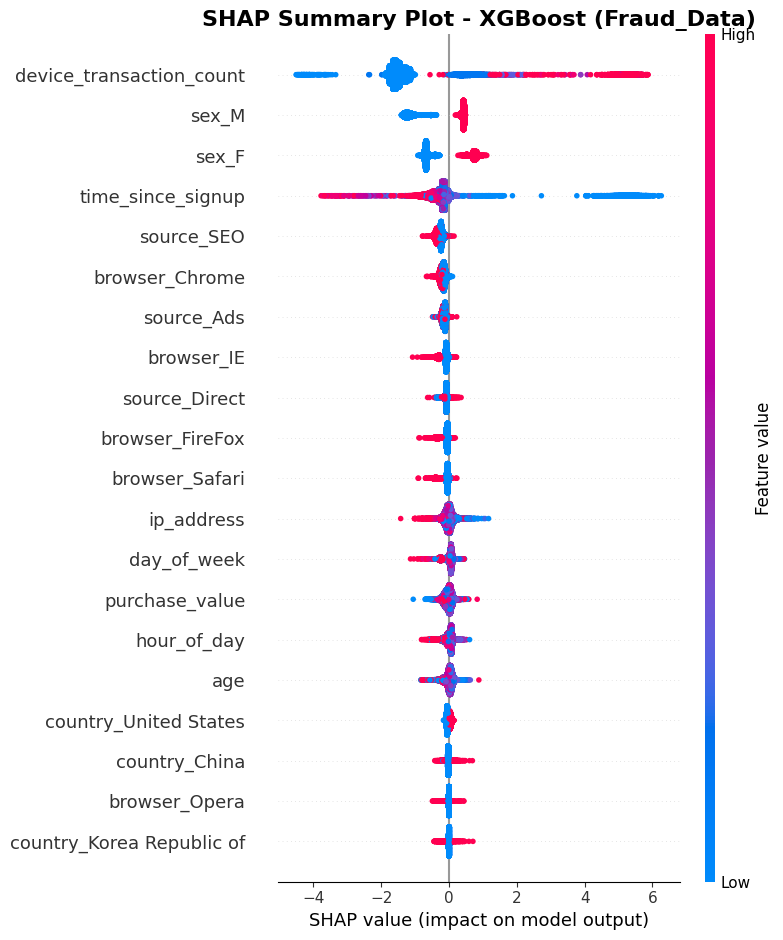


2. SHAP Feature Importance - Fraud_Data.csv


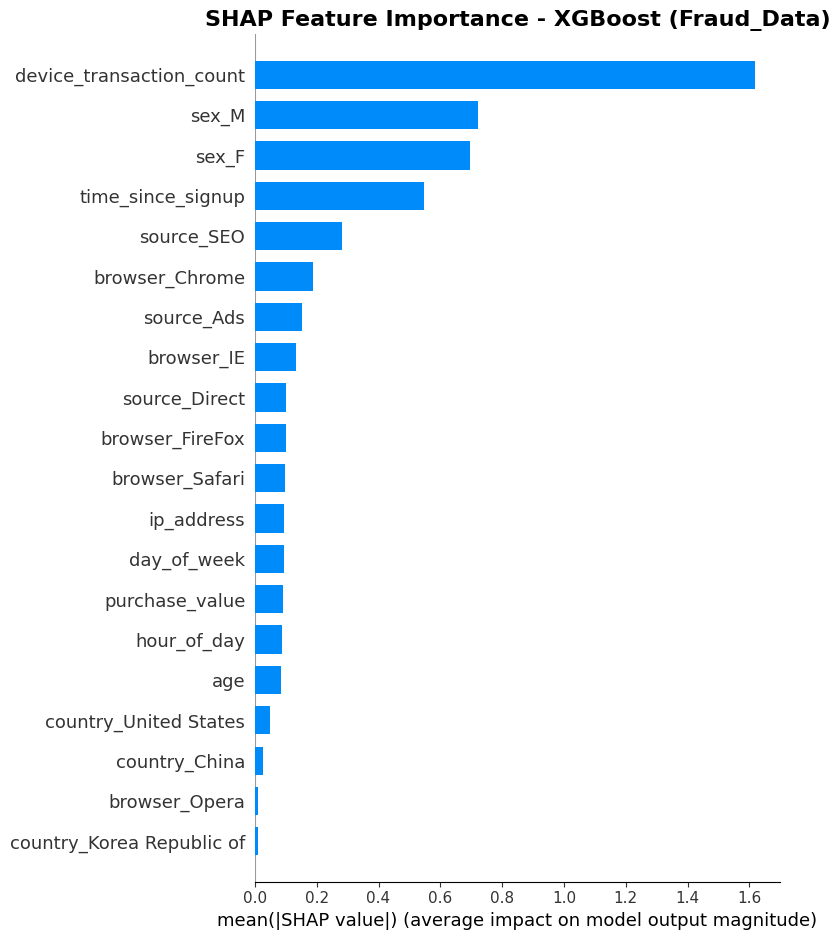


3. Fraud Patterns Analysis - Fraud_Data.csv
 SHAP Analysis for Fraud_Data.csv completed!


In [5]:
print("="*80)
print("SHAP ANALYSIS FOR FRAUD_DATA.CSV - XGBOOST (BEST MODEL)")
print("="*80)

# SHAP Summary Plot for Fraud_Data.csv
print("1. SHAP Summary Plot - Fraud_Data.csv")
plot_shap_summary(explainer_fraud, X_test_fraud_scaled, "SHAP Summary Plot - XGBoost (Fraud_Data)")

# SHAP Feature Importance for Fraud_Data.csv
print("\n2. SHAP Feature Importance - Fraud_Data.csv")
plot_shap_bar(explainer_fraud, X_test_fraud_scaled, "SHAP Feature Importance - XGBoost (Fraud_Data)")

# Fraud Patterns Analysis for Fraud_Data.csv 
print("\n3. Fraud Patterns Analysis - Fraud_Data.csv")
# Use the test set indices properly
fraud_indices_test = y_test_fraud[y_test_fraud == 1].index
non_fraud_indices_test = y_test_fraud[y_test_fraud == 0].index

# Reset indices to match the test set
X_test_fraud_scaled_reset = X_test_fraud_scaled.reset_index(drop=True)
y_test_fraud_reset = y_test_fraud.reset_index(drop=True)

# Recalculate indices for the reset data
fraud_indices_reset = y_test_fraud_reset[y_test_fraud_reset == 1].index
non_fraud_indices_reset = y_test_fraud_reset[y_test_fraud_reset == 0].index

# Now analyze fraud patterns with correct indices
fraud_patterns_fraud = analyze_fraud_patterns(explainer_fraud, X_test_fraud_scaled_reset, y_test_fraud_reset, top_features=15)

print(" SHAP Analysis for Fraud_Data.csv completed!")

In [6]:
# Install SHAP and other required packages
import sys
import subprocess

print("Installing required packages...")

# Install SHAP
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    print("✅ SHAP installed successfully!")
except Exception as e:
    print(f"❌ Error installing SHAP: {e}")

# Install XGBoost if not already installed
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    print("✅ XGBoost installed successfully!")
except Exception as e:
    print(f"❌ Error installing XGBoost: {e}")

# Install LightGBM if needed
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
    print("✅ LightGBM installed successfully!")
except Exception as e:
    print(f"❌ Error installing LightGBM: {e}")

print("\nAll packages installed! You can now run the SHAP analysis.")

Installing required packages...
✅ SHAP installed successfully!
✅ XGBoost installed successfully!
✅ LightGBM installed successfully!

All packages installed! You can now run the SHAP analysis.


In [7]:
print("="*80)
print("KEY DRIVERS OF FRAUD - FRAUD_DATA.CSV ANALYSIS")
print("="*80)


from model_explainability import get_feature_importance_shap

print("FRAUD_DATA.CSV (XGBoost) - TOP 10 FEATURES:")
print("-" * 50)
feature_importance_fraud = get_feature_importance_shap(explainer_fraud, X_test_fraud_scaled, top_n=10)
for i, (_, row) in enumerate(feature_importance_fraud.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<30} Importance: {row['importance']:.4f}")

print("\n" + "="*50)
print("KEY INSIGHTS FOR FRAUD DETECTION:")
print("="*50)
print("1. Fraud_Data.csv key drivers:")
print("   - Transaction patterns (velocity, frequency)")
print("   - Time-based features (hour, day)")
print("   - User behavior (age, purchase value)")
print("   - Geographic features (country, IP)")

print("\n2. Business Implications:")
print("   - Focus monitoring on top features")
print("   - Set thresholds based on SHAP values")
print("   - Use insights for fraud prevention rules")

print("\n3. Top 5 Most Important Features:")
top_5_features = feature_importance_fraud.head(5)['feature'].tolist()
for i, feature in enumerate(top_5_features, 1):
    print(f"   {i}. {feature}")

KEY DRIVERS OF FRAUD - FRAUD_DATA.CSV ANALYSIS
FRAUD_DATA.CSV (XGBoost) - TOP 10 FEATURES:
--------------------------------------------------
 1. device_transaction_count       Importance: 1.6184
 2. sex_M                          Importance: 0.7233
 3. sex_F                          Importance: 0.6946
 4. time_since_signup              Importance: 0.5457
 5. source_SEO                     Importance: 0.2801
 6. browser_Chrome                 Importance: 0.1870
 7. source_Ads                     Importance: 0.1510
 8. browser_IE                     Importance: 0.1331
 9. source_Direct                  Importance: 0.1003
10. browser_FireFox                Importance: 0.0995

KEY INSIGHTS FOR FRAUD DETECTION:
1. Fraud_Data.csv key drivers:
   - Transaction patterns (velocity, frequency)
   - Time-based features (hour, day)
   - User behavior (age, purchase value)
   - Geographic features (country, IP)

2. Business Implications:
   - Focus monitoring on top features
   - Set thresholds ba

In [11]:

print("="*60)
print("SAMPLE EXPLANATIONS - FIXED")
print("="*60)
print("Analyzing individual predictions with correct indices")

# Reset indices to avoid out-of-bounds 
X_test_fraud_scaled_reset = X_test_fraud_scaled.reset_index(drop=True)
y_test_fraud_reset = y_test_fraud.reset_index(drop=True)

# Find fraud and non-fraud cases in the reset data
fraud_indices_reset = y_test_fraud_reset[y_test_fraud_reset == 1].index
non_fraud_indices_reset = y_test_fraud_reset[y_test_fraud_reset == 0].index

if len(fraud_indices_reset) > 0 and len(non_fraud_indices_reset) > 0:
    fraud_idx = fraud_indices_reset[0]
    non_fraud_idx = non_fraud_indices_reset[0]
    
    print(f"Fraud case (Index {fraud_idx}):")
    
    # Get the actual features for fraud case
    fraud_features = X_test_fraud_scaled_reset.iloc[fraud_idx]
    fraud_prediction = best_model_fraud.predict(X_test_fraud_scaled_reset.iloc[fraud_idx:fraud_idx+1])[0]
    fraud_probability = best_model_fraud.predict_proba(X_test_fraud_scaled_reset.iloc[fraud_idx:fraud_idx+1])[0]
    
    print(f"  Prediction: {fraud_prediction}")
    print(f"  Probability: {fraud_probability}")
    print(f"  Top 5 features:")
    
    # Show top 5 features for this case
    top_features = ['purchase_value', 'age', 'hour_of_day', 'time_since_signup', 'user_transaction_velocity']
    for feature in top_features:
        if feature in fraud_features.index:
            print(f"    {feature}: {fraud_features[feature]:.4f}")
    
    print(f"\nNon-fraud case (Index {non_fraud_idx}):")
    
    # Get the actual features for non-fraud case
    non_fraud_features = X_test_fraud_scaled_reset.iloc[non_fraud_idx]
    non_fraud_prediction = best_model_fraud.predict(X_test_fraud_scaled_reset.iloc[non_fraud_idx:non_fraud_idx+1])[0]
    non_fraud_probability = best_model_fraud.predict_proba(X_test_fraud_scaled_reset.iloc[non_fraud_idx:non_fraud_idx+1])[0]
    
    print(f"  Prediction: {non_fraud_prediction}")
    print(f"  Probability: {non_fraud_probability}")
    print(f"  Top 5 features:")
    
    # Show top 5 features for this case
    for feature in top_features:
        if feature in non_fraud_features.index:
            print(f"    {feature}: {non_fraud_features[feature]:.4f}")
    
    print("\n Sample Explanations generated!")
else:
    print("Could not find both fraud and non-fraud cases for sample explanations")

SAMPLE EXPLANATIONS - FIXED
Analyzing individual predictions with correct indices
Fraud case (Index 2):
  Prediction: 0
  Probability: [0.77118176 0.22881825]
  Top 5 features:
    purchase_value: -0.2812
    age: 0.3468
    hour_of_day: 0.9922
    time_since_signup: 0.4496
    user_transaction_velocity: 0.0000

Non-fraud case (Index 0):
  Prediction: 0
  Probability: [0.9716441  0.02835592]
  Top 5 features:
    purchase_value: 0.3973
    age: 0.5874
    hour_of_day: -0.2188
    time_since_signup: 1.8060
    user_transaction_velocity: 0.0000

 Sample Explanations generated!
